# Exame de Época Especial - Física Computacional 2020/21

## Problema 1 - Condensador Cilíndrico

Considere um condensador cilíndrico composto por um núcleo metálico (de raio $R$) e uma placa concêntrica de cobertura com um raio $5R$. O núcleo é mantido a um potencial $V_{0}$ enquanto que a cobertura se encontra ligada à terra. O volume entre as placas tem uma constante dielétrica igual à do vácuo, mas está semi-preenchido por um líquido eletrizado de carga uniforme. Por simetria, podemos limitar a análise a um plano transversal ao cilindro, de tal modo que o potencial elétrico obedece à equação de Poisson em coordenadas polares,

$$
\frac{\partial^{2}V(r,\theta)}{\partial r^{2}}+\frac{1}{r}\frac{\partial V(r,\theta)}{\partial r}+\frac{1}{r^{2}}\frac{\partial^{2}V(r,\theta)}{\partial\theta^{2}}=-\sigma_{0}\chi(\theta),
$$

onde $\chi(\theta)=1$ para $\theta\in[-\pi,0]$ e zero no restante domínio ($r$ medido em unidades de $R$, $V(r,\theta)$ em unidades de $V_{0}$). Se considerarmos uma malha uniforme em $(r,\theta)$ com espaçamentos $(\delta r,\delta\theta)$, então a equação de Poisson pode ser discretizada com diferenças finitas da seguinte forma:

$$
\frac{V_{i+1,j}+V_{i-1,j}-2V_{i,j}}{\delta r^{2}}+\frac{1}{r_{i}}\left(\frac{V_{i+1,j}-V_{i-1,j}}{2\delta r}\right)+\frac{1}{r_{i}^{2}}\left(\frac{V_{i,j+1}+V_{i,j-1}-2V_{i,j}}{\delta\theta^{2}}\right)+\sigma_{0}\chi(\theta_{j})=0.
$$

In [64]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

import time

1. Escreva a equação de diferenças finitas numa forma auto-consistente que possa ser resolvida com um método de relaxação.

Temos a seguinte equação:


$$
\begin{align*}
&\ \frac{V_{i+1,j}+V_{i-1,j}-2V_{i,j}}{\delta r^{2}}+\frac{1}{r_{i}}\left(\frac{V_{i+1,j}-V_{i-1,j}}{2\delta r}\right)+\frac{1}{r_{i}^{2}}\left(\frac{V_{i,j+1}+V_{i,j-1}-2V_{i,j}}{\delta\theta^{2}}\right)+\sigma_{0}\chi(\theta_{j})=0
\hArr
\\\\

\hArr&\ \frac{V_{i+1,j}+V_{i-1,j}}{\delta r^{2}}+\frac{1}{r_{i}}\left(\frac{V_{i+1,j}-V_{i-1,j}}{2\delta r}\right)+\frac{1}{r_{i}^{2}}\left(\frac{V_{i,j+1}+V_{i,j-1}}{\delta\theta^{2}}\right)+\sigma_{0}\chi(\theta_{j})=2V_{i, j}\left(\frac{1}{\delta r^2} + \frac1{r_i^2\delta \theta^2}\right)
\\\\

\hArr&\ \frac12\left(\frac{1}{\delta r^2} + \frac1{r_i^2\cdot\delta \theta^2}\right)^{-1}\left[\frac{V_{i+1,j}+V_{i-1,j}}{\delta r^{2}}+\frac{1}{r_{i}}\left(\frac{V_{i+1,j}-V_{i-1,j}}{2\delta r}\right)+\frac{1}{r_{i}^{2}}\left(\frac{V_{i,j+1}+V_{i,j-1}}{\delta\theta^{2}}\right)+\sigma_{0}\chi(\theta_{j})\right] = V_{i, j}


\end{align*}
$$

In [65]:
#Responda Aqui

2. Escreva uma função de $\texttt{python}$ que resolva a equação por um método de Gauss-Seidel com um parâmetro de sobre-relaxação $\omega\!=\!0.94$. A função deverá assumir uma tolerância $\epsilon$ na convergência, um número de pontos na malha ($N$) e um $\sigma_{0}$ arbitrários.

Vamos supor que a malha pode ser representada por uma matriz $\phi$ de dimensões $N \times N$, em que o elemento $\phi_{i, j}$ está na posição $(r_i, \theta_j)$. É importante notar que isto quer dizer que temos menor densidade de pontos para $r$ maior, o que poderá afetar o resultado! 

**Nota**: Deste modo temos $N^2$ pontos em vez de $N$, mas isso simplifica bastante o nosso código!

In [66]:
def poisson2d(phi: np.ndarray, solve: np.ndarray, dr: float, dtheta: float, ff: np.ndarray, eps: float=1e-5, omega: float=0.94, rmax: float=5) -> np.ndarray:
    """
        Resolve a equação de Poisson a 2D `nabla^2 phi = func` em coordenadas polares usando o método de Gauss-Seidel com sobrerelaxação começando com estimativa inicial `phi` e terminando quando o passo em cada ponto for menor que `eps`.

        Resolve a equação com r em [0, rmax] e theta em [0, 2pi].

        A matriz `solve` contém True caso o ponto esteja na área governada pela equação e contém False caso esteja na fronteira.

        A matriz `ff` contém os valores de func avaliados nos pontos da grelha.
    """

    # Valores úteis
    dr2 = dr**2
    dtheta2 = dtheta**2

    # Dimensões do problema
    Nr, Ntheta = phi.shape

    erro = eps + 1
    while erro > eps:
        erro = 0

        # Iterar sobre todos os pontos
        for i in range(Nr):
            for j in range(Ntheta):
                # Fazer um passo de Gauss-Seidel
                if solve[i, j]:
                    ri = i / (Nr - 1) * rmax

                    # Usamos módulo na coordenada j pois theta é uma coordenada cíclica!
                    phinew = (1/2) * (1/dr2 + 1/(ri ** 2 * dtheta2))**(-1) * ( (phi[i + 1, j] + phi[i - 1, j]) / dr2 + (phi[i+1, j] - phi[i-1, j])/(ri * 2 * dr) + (phi[i, (j+1) % Ntheta] + phi[i, (j-1) % Ntheta])/(ri**2 * dtheta2) + ff[i, j])
                    step = (1 + omega) * (phinew - phi[i, j])
                    phi[i, j] += step

                    # O erro é o maior passo que demos
                    erro = max(erro, abs(step))
    
    return phi


def resolver(N: int, sigma0: float, eps: float=1e-5, omega: float=0.94, rmax: float=5):
    """
        Função que resolver o problema pedido!
    """

    # Calcular a matriz do potencial e da função ff = sigma0 * chi(theta)
    phi = np.zeros((N, N))

    ff = np.zeros_like(phi)
    solve = np.full_like(phi, True)

    # Cada linha corresponde a um valor de r e cada coluna a um valor de theta


    # Aplicar as condições fronteira e criar a matriz com os valores de sigma0 * chi(theta)

    # Se r <= R então estamos no núcleo e o potencial é V_0 = 1
    solve[:N//5, :] = False
    phi[:N//5, :] = 1
    
    # Se theta estiver em [pi, 2pi] então ff = sigma0, caso contrário é zero
    ff[:, N//2:] = sigma0

    # Se r == 5R então estamos na cobertura e o potencial é nulo
    solve[-1, :] = False


    # Calcular dr e dtheta
    dr = rmax / (N - 1)
    dtheta = 2 * np.pi / N

    # Se tivermos dois pontos:
        # O espaçamento em r é igual a rmax
        # O espaçamento em theta é igual a pi!

    return poisson2d(phi, solve, dr, dtheta, ff, eps, omega, rmax)

3. Tomando $\sigma_{0}\!=\!0$, calcule $V(r,\theta)$ numa malha de $100\!\times\!100$ pontos usando $\epsilon\!=\!10^{-5}$.

      (a) Represente o potencial num gráfico de contorno polar [Nota: A biblioteca $\texttt{matplotlib}$ permite fazer gráficos de contorno em coordenadas polares.]

Responda Aqui

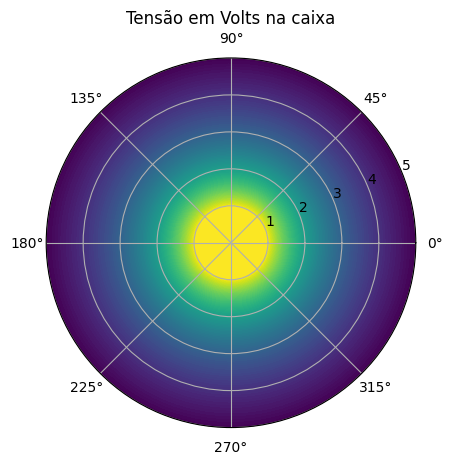

In [83]:
# Parâmetro
N = 100

# Resolver a equação
phi = resolver(N, 0, 1e-5, 0.94)

# Criar os valores de r e theta
r = np.linspace(0, 5, N)
theta = np.linspace(0, 2 * np.pi, N)

rm, tm = np.meshgrid(r, theta)


# Representar graficamente
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

ax.contourf(tm, rm, phi.T, levels=N)

plt.title("Tensão em Volts na caixa")
plt.show()

(b) Neste caso, a simetria cilíndrica impõe que $V(r,\theta)\!=\!f(r)$ e a equação de Laplace pode ser resolvida analiticamente. Compare a solução analítica com o que obteve numericamente.

A equação de Poisson passa para:

$$
\frac{d^2V}{dr^2} + \frac1r\frac{dV}{dr} = 0
$$

Que tem solução:

$$
V(r) = C\ln(r) + D
$$

Usando as condições fronteira temos:

$$
C = -\frac1{\ln(5)}
\\
D = 1
$$

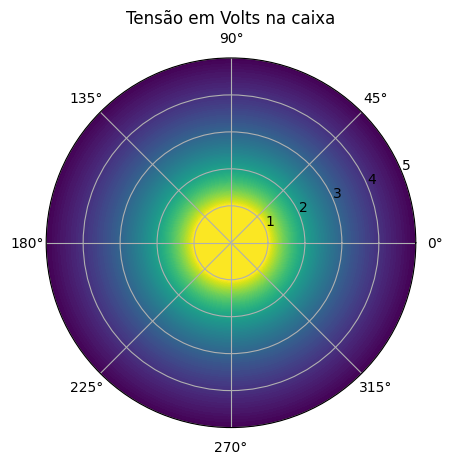

In [85]:
# Temos então:
C = -1 / np.log(5)
D = 1


# Calcular o potencial
phi = np.zeros((N, N))

for i in range(0, N):

    # Se r <= R então estamos no núcleo e o potencial é V_0 = 1
    if i <= N//5:
        phi[i, :] = 1
    
    # Caso contrário a nossa solução vale
    else:
        ri = i / (N - 1) * 5
        phi[i, :] = C * np.log(ri) + D


# Representar graficamente
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

ax.contourf(tm, rm, phi.T, levels=N)

plt.title("Tensão em Volts na caixa")
plt.show()

Responda Aqui

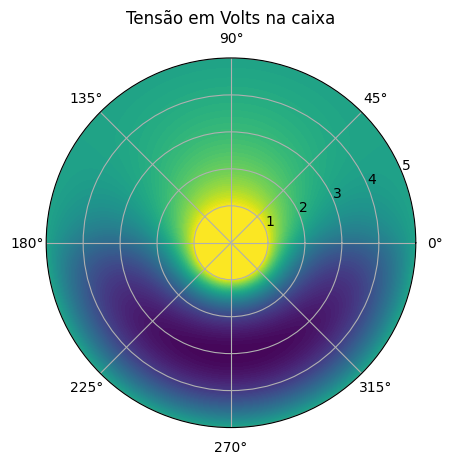

In [89]:
# Parâmetro
N = 100

# Resolver a equação
phi = resolver(N, -0.8, 1e-5, 0.94)

# Criar os valores de r e theta
r = np.linspace(0, 5, N)
theta = np.linspace(0, 2 * np.pi, N)

rm, tm = np.meshgrid(r, theta)


# Representar graficamente
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

ax.contourf(tm, rm, phi.T, levels=N)

plt.title("Tensão em Volts na caixa")
plt.show()

4. Calcule $V(r,\theta)$ com $\sigma_{0}\!=\!-0.8$, numa malha de $200\!\times\!200$ pontos usando $\epsilon\!=\!10^{-5}$. Com esta solução determine e represente a densidade de carga induzida nas duas placas do condensador.

Responda Aqui

In [69]:
#Responda Aqui

5. Implementando um método de Simpson-$\frac{1}{3}$, determine a carga total induzida em ambas as placas. Verifique numericamente que esta carga é simétrica da carga total contida no fluído eletrizado. Justifique porque é que isto tem que ser verdade.

Responda Aqui

In [70]:
#Responda Aqui

# Problema 2
Considere um electrão a mover-se como uma partícula clássica a três dimensões, sob a acção de um potencial isotrópico $V\left(\mathbf{r}\right)=V\left(r\right)$ dado por 

$$
V\left(r\right)=\beta r^{4}+\alpha r^{2}
$$

onde $r=\left|\mathbf{r}\right|$ é a distância à origem, $\beta>0$ e $\alpha<0$.

1. [10%] Calcule analiticamente os pontos de equilíbrio estável e instável deste sistema. Qual é a energia mínima necessária (em função de $\beta$ e $\alpha$) para que o electrão consiga atravessar o máximo local?

Responda Aqui

In [71]:
#Responda Aqui

2. [20%] Escreva as equações de movimento deste sistema. Adimensionalize-as, medindo distâncias em unidades de $x_{0}=\sqrt{\frac{-\alpha}{2\beta}}$ e tempos em unidades de $t_{0}=\sqrt{\frac{m}{-2\alpha}}$. Qual é o significado físico destas quantidades?

Responda Aqui

In [72]:
#Responda Aqui

3. [25%] Implemente uma rotina Runge-Kutta4 que integre estas equações de movimento e use-a para estudar o movimento do electrão, partindo de $\mathbf{r}\!=\!(1.2,0,0)$ com velocidade inicial. Represente o movimento desde $t=0$ até $t=30$. Averigue que a energia total é conservada (exprima-a em unidades de $V_{0}\!=\!\frac{\alpha^{2}}{4\beta}$). Qual é o significado físico de $V_{0}$?

Responda Aqui

In [73]:
#Responda Aqui

4. [25%] Assumindo que o electrão parte da posição $\mathbf{r}\!=\!(1,\!0,\!0)$ com uma velocidade $\mathbf{v}\!=\!\left(u,\!0,\!0\right)$, use o método da bissecção para calcular $u$ tal que

    (a) $E=0$;

    (b) $E=1$.

Responda Aqui

In [74]:
#Responda Aqui    

5. [20%] Nas mesmas condições da alínea anterior, calcule a posição média do electrão ao longo do tempo (tempo máximo $t\!=\!100$) para uma lista de $100$ energias entre $-0.99$ e $1$.

Responda Aqui

In [75]:
#Responda Aqui

#### Bom Trabalho